In [1]:
import numpy as np
import awkward as ak
from typing import TypeVar, Tuple
ak_array = TypeVar('ak_array')
coffea_nanoevent = TypeVar('coffea_nanoevent') 


def fsr_recovery_old(events):
    fsrPhotonsToRecover = (
        (events.Muon.fsrPhotonIdx >= 0)
        & (events.Muon.matched_fsrPhoton.relIso03 < 1.8)
        & (events.Muon.matched_fsrPhoton.dROverEt2 < 0.012)
        & (events.Muon.matched_fsrPhoton.pt / events.Muon.pt < 0.4)
        & (abs(events.Muon.matched_fsrPhoton.eta) < 2.4)
    )
    fsrPhotonsToRecover = ak.fill_none(fsrPhotonsToRecover, False)

    px = ak.zeros_like(events.Muon.pt)
    py = ak.zeros_like(events.Muon.pt)
    pz = ak.zeros_like(events.Muon.pt)
    e = ak.zeros_like(events.Muon.pt)

    fsr = {
        "pt": events.Muon.matched_fsrPhoton.pt,
        "eta": events.Muon.matched_fsrPhoton.eta,
        "phi": events.Muon.matched_fsrPhoton.phi,
        "mass": 0.0,
    }
    print(f"fsr pt: {fsr['pt'].compute()}")
    for obj in [events.Muon, fsr]:
        px_ = obj["pt"] * np.cos(obj["phi"])
        py_ = obj["pt"] * np.sin(obj["phi"])
        pz_ = obj["pt"] * np.sinh(obj["eta"])
        e_ = np.sqrt(px_**2 + py_**2 + pz_**2 + obj["mass"] ** 2)

        px = px + px_
        py = py + py_
        pz = pz + pz_
        e = e + e_

    pt = np.sqrt(px**2 + py**2)
    print(f"type(pt): {(pt.type)}")
    print(f"total nmuons applied with fsrPhotons: {ak.sum(fsrPhotonsToRecover,axis=None)}")
    eta = np.arcsinh(pz / pt)
    phi = np.arctan2(py, px)
    mass = np.sqrt(e**2 - px**2 - py**2 - pz**2)
    print(f"type(eta): {(eta.type)}")
    print(f"type(phi): {(phi.type)}")
    print(f"type(mass): {(mass.type)}")
    iso = (events.Muon.pfRelIso04_all * events.Muon.pt - events.Muon.matched_fsrPhoton.pt) / pt

    events["Muon", "pt_fsr"] = ak.where(fsrPhotonsToRecover, pt, events.Muon.pt)
    # events["Muon", "eta_fsr"] = ak.where(fsrPhotonsToRecover, eta, events.Muon.eta)
    # events["Muon", "phi_fsr"] = ak.where(fsrPhotonsToRecover, phi, events.Muon.phi)
    # events["Muon", "mass_fsr"] = ak.where(fsrPhotonsToRecover, mass, events.Muon.mass)
    # events["Muon", "iso_fsr"] = ak.where(fsrPhotonsToRecover, iso, events.Muon.pfRelIso04_all)
    return fsrPhotonsToRecover


def fsr_recovery_new(events: coffea_nanoevent) -> ak_array:
    fsrPhotonsToRecover = (
        (events.Muon.fsrPhotonIdx >= 0) # pick rows and cols that have values (-1 means no photon found)
        & (events.Muon.matched_fsrPhoton.relIso03 < 1.8)
        & (events.Muon.matched_fsrPhoton.dROverEt2 < 0.012)
        & (events.Muon.matched_fsrPhoton.pt / events.Muon.pt < 0.4) # suppress Zgamma -> mumu contanmination
        & (abs(events.Muon.matched_fsrPhoton.eta) < 2.4)
    ) 
    
    fsrPhotonsToRecover = ak.fill_none(fsrPhotonsToRecover, False) 
    # print(f"fsrPhotonsToRecover sum: {ak.sum(fsrPhotonsToRecover, axis=None).compute()}")
    # print(f"fsrPhotonsToRecover : {ak.flatten(fsrPhotonsToRecover[fsrPhotonsToRecover]).compute()}")
    # add mass and charge as otherwise you can't add two lorentzvectors
    events["FsrPhoton", "mass"] = 0 
    events["FsrPhoton", "charge"] = 0 
    # print(f"events.Muon.matched_fsrPhoton.mass: {events.Muon.matched_fsrPhoton.mass}")
    # print(f"events.FsrPhoton: {events.FsrPhoton[fsrPhotonsToRecover].compute()}")
    # print(f"events.Muon.matched_fsrPhoton: {ak.flatten(events.Muon.matched_fsrPhoton[fsrPhotonsToRecover]).compute()}")
    
    fsr_muons = events.Muon.matched_fsrPhoton + events.Muon # None means there weren't matched fsrphotons
    
    fsr_iso = (events.Muon.pfRelIso04_all * events.Muon.pt - events.Muon.matched_fsrPhoton.pt) / fsr_muons.pt
   
    events["Muon", "pt_fsr"] = ak.where(fsrPhotonsToRecover, fsr_muons.pt, events.Muon.pt)
    # events["Muon", "eta_fsr"] = ak.where(fsrPhotonsToRecover, fsr_muons.eta, events.Muon.eta)
    # events["Muon", "phi_fsr"] = ak.where(fsrPhotonsToRecover, fsr_muons.phi, events.Muon.phi)
    # events["Muon", "mass_fsr"] = ak.where(fsrPhotonsToRecover, fsr_muons.mass, events.Muon.mass)
    # events["Muon", "iso_fsr"] = ak.where(fsrPhotonsToRecover, fsr_iso, events.Muon.pfRelIso04_all)
    
    
    fsr_filter = (ak.sum(fsrPhotonsToRecover, axis=1) > 0)

    fsr_events = events[fsr_filter]
    argmax = ak.argmax(fsr_events.Muon.pt_fsr, axis=1)
    argmax_not_leading = argmax != 0
    argmax_not_leading_events = fsr_events[argmax_not_leading]
    return fsrPhotonsToRecover # return boolean filter for geofit

In [2]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from distributed import Client
# fname = "root://eos.cms.rcac.purdue.edu:1094///store/mc/RunIISummer20UL18NanoAODv9/DYJetsToLL_M-100to200_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/40000/AA6F89B0-EDAA-3942-A3BB-BC3709722EB4.root" # dy_M-100To200
client = Client(n_workers=8,  threads_per_worker=1, processes=True, memory_limit='3 GiB') 
# file_dict = {"root://eos.cms.rcac.purdue.edu:1094///store/mc/RunIISummer20UL18NanoAODv9/DYJetsToLL_M-100to200_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/40000/AA6F89B0-EDAA-3942-A3BB-BC3709722EB4.root": {"object_path": "Events", "steps": [[0, 100017]], "uuid": "b16b5dea-fbcd-11ed-bae7-a2a0b8bcbeef"}}
file_dict = {"root://eos.cms.rcac.purdue.edu:1094///store/mc/RunIISummer20UL18NanoAODv9/DYJetsToLL_M-100to200_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/40000/AA6F89B0-EDAA-3942-A3BB-BC3709722EB4.root": {"object_path": "Events", "steps": [[0, 1000017]], "uuid": "b16b5dea-fbcd-11ed-bae7-a2a0b8bcbeef"}}


/depot/cms/kernels/coffea2024/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44665 instead
  warnings.warn(


In [3]:
events = NanoEventsFactory.from_root(
    # {fname: "Events"},
    file_dict,
    schemaclass=NanoAODSchema,
    metadata={"dataset": "DYJets"},
    # delayed=False,
    # entry_stop = 10017,
).events()
nmuons = ak.num(events.Muon, axis=1)
good_events = nmuons==2
# events = events[good_events]
fsr_recovery_old(events)
padded_muons = ak.pad_none(events.Muon, target=2, clip=True)
muon_flip = padded_muons.pt[:,0] < padded_muons.pt[:,1]  
muon_flip = ak.fill_none(muon_flip, value=False)
# take the subleading muon values if that now has higher pt after corrections
mu1 = ak.where(muon_flip, padded_muons[:,1], padded_muons[:,0])
mu2 = ak.where(muon_flip, padded_muons[:,0], padded_muons[:,1])
mu1_pt_old = mu1.pt
mu2_pt_old = mu2.pt
print(mu1_pt_old.compute())

/depot/cms/kernels/coffea2024/lib/python3.10/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/depot/cms/kernels/coffea2024/lib/python3.10/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're 

fsr pt: [[], [], [None], [None], [], ..., [], [None, None], [None], [None, None], []]
type(pt): ?? * var * ?float32
total nmuons applied with fsrPhotons: dask.awkward<sum, type=Scalar, dtype=int64>
type(eta): ?? * var * ?float32
type(phi): ?? * var * ?float32
type(mass): ?? * var * ?float32


/depot/cms/kernels/coffea2024/lib/python3.10/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


[None, None, 7.23, 4.16, None, 13.3, ..., None, None, 75.3, 25.1, 57, None]


In [4]:
# file_dict = {"root://eos.cms.rcac.purdue.edu:1094///store/mc/RunIISummer20UL18NanoAODv9/DYJetsToLL_M-100to200_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/40000/AA6F89B0-EDAA-3942-A3BB-BC3709722EB4.root": {"object_path": "Events", "steps": [[0, 10017]], "uuid": "b16b5dea-fbcd-11ed-bae7-a2a0b8bcbeef"}}
events = NanoEventsFactory.from_root(
    # {fname: "Events"},
    file_dict,
    schemaclass=NanoAODSchema,
    metadata={"dataset": "DYJets"},
    # delayed=False,
    # entry_stop = 10017,
).events()
nmuons = ak.num(events.Muon, axis=1)
good_events = nmuons==2
# events = events[good_events]
fsr_recovery_new(events)
padded_muons = ak.pad_none(events.Muon, target=2, clip=True)
muon_flip = padded_muons.pt[:,0] < padded_muons.pt[:,1]  
muon_flip = ak.fill_none(muon_flip, value=False)
# take the subleading muon values if that now has higher pt after corrections
mu1 = ak.where(muon_flip, padded_muons[:,1], padded_muons[:,0])
mu2 = ak.where(muon_flip, padded_muons[:,0], padded_muons[:,1])
mu1_pt_new = mu1.pt
mu2_pt_new = mu2.pt
print(mu1_pt_new.compute())

/depot/cms/kernels/coffea2024/lib/python3.10/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


[None, None, 7.23, 4.16, None, 13.3, ..., None, None, 75.3, 25.1, 57, None]


/depot/cms/kernels/coffea2024/lib/python3.10/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/depot/cms/kernels/coffea2024/lib/python3.10/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're 

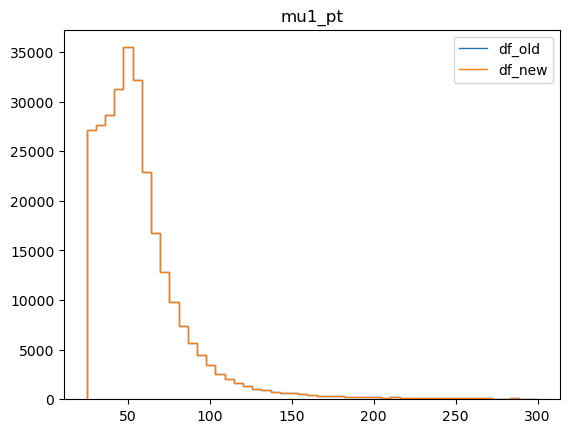

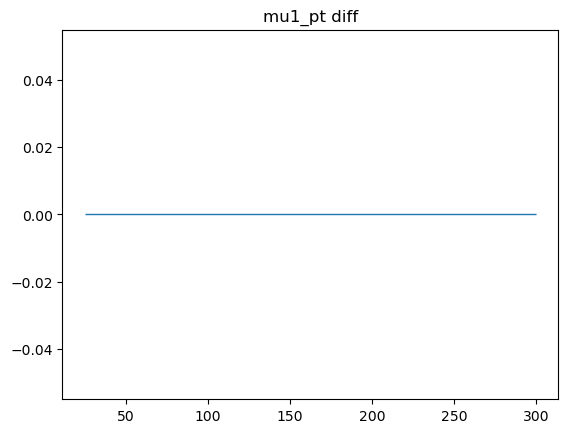

In [5]:
import matplotlib.pyplot as plt
binning_map = {
    "pt" : [25, 300, 50],
}
variables = ["mu1_pt"
            ]

for var in variables:
    kin = var.split("_")[-1]
    binning = np.linspace(*binning_map[kin])
    hist_old, edges = np.histogram(mu1_pt_old.compute(), bins=binning)
    hist_new, _= np.histogram(mu1_pt_new.compute(), bins=binning)
    
    plt.stairs(hist_old, edges, label = "df_old")
    plt.stairs(hist_new, edges, label = "df_new")
    plt.legend(loc="upper right")
    plt.title(f"{var}")
    plt.show()
    plt.stairs((hist_new-hist_old), edges)
    plt.title(f"{var}"+" diff")
    plt.show()